In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd 'gdrive/My Drive/Colab Notebooks/Udacity_DLND/RGB_to_GRAYSCALE_Autoencoder-'
  
!pwd


/content/gdrive/My Drive/Colab Notebooks/Udacity_DLND/RGB_to_GRAYSCALE_Autoencoder-
/content/gdrive/My Drive/Colab Notebooks/Udacity_DLND/RGB_to_GRAYSCALE_Autoencoder-


In [0]:
import torch
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2

# np.set_printoptions(threshold=np.inf)

In [4]:
from glob import glob

np.random.seed(313)

# load filenames for color and gray images
color_files = np.array(glob("color_images/*.jpg"))
gray_files = np.array(glob("gray_images/*.jpg"))

# print number of images in each dataset
print('There are %d total color images.' % len(color_files))
print('There are %d total gray images.' % len(gray_files))

There are 3670 total color images.
There are 3670 total gray images.


In [0]:
# num_images = 3670
num_images = len(color_files)

In [6]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [0]:
# dataset = []

# for i in range(1, num_images+1):
#     img = cv2.imread("color_images/color_" +str(i) +".jpg" )
#     dataset.append(np.array(img))

# dataset_source = np.asarray(dataset)
# print(dataset_source.shape)

# dataset_tar = []

# for i in range(1, num_images+1):
#     img = cv2.imread("gray_images/gray_" +str(i) +".jpg", 0)    
#     dataset_tar.append(np.array(img))

# dataset_target = np.asarray(dataset_tar)
# print(dataset_target.shape)


## Reference: https://stackoverflow.com/questions/45099554/how-to-simplify-dataloader-for-autoencoder-in-pytorch

import PIL
class ImageLoader(torch.utils.data.Dataset):
  
  def __init__(self, source_root, target_root, source_tform=None, target_tform=None, imgloader=PIL.Image.open):
      super(ImageLoader, self).__init__()

      self.source_root = source_root
      self.target_root = target_root

      self.source_filenames = sorted(glob(source_root))
      self.target_filenames = sorted(glob(target_root))

      self.source_tform = source_tform
      self.target_tform = target_tform

      self.imgloader = imgloader

  def __len__(self):
      return len(self.source_filenames)

  def __getitem__(self, i):
      source, target = self.imgloader(self.source_filenames[i]), self.imgloader(self.target_filenames[i])  # io.imread(self.filenames[i])
      
      if self.source_tform:
          source = self.source_tform(source)
      
      if self.target_tform:
          target = self.target_tform(target)
      
      return source, target


In [0]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


batch_size       = 128
validation_split = 0.2
shuffle_dataset  = True
random_seed      = 313

source_depth_transform = transforms.Compose([transforms.ToTensor()])

target_depth_transform = transforms.Compose([transforms.ToTensor()])

dataset = ImageLoader(source_root='color_images/color_*.jpg', target_root='gray_images/gray_*.jpg',
                      source_tform=source_depth_transform, target_tform=target_depth_transform)



## Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [13]:
len(train_loader.sampler)

2936

In [14]:
# Test Code for dataloader's verification

dataiter = iter(train_loader)
source_images, target_images = dataiter.next()
print(source_images.size())
print(target_images.size())

torch.Size([28, 3, 128, 128])
torch.Size([28, 1, 128, 128])


In [18]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        ## encoder layers ##
        self.Econv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.Dconv = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        
        


    def forward(self, x):
        ## encode ##
        x = F.relu(self.Econv(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        ## decode ##
        x = F.upsample(x, scale_factor=2, mode='nearest')
        # print(x.shape)
        x = self.Dconv(x)
        # print(x.shape)
                      
        # x = F.sigmoid(self.out(x))
                
        return x

# initialize the NN
model = AutoEncoder()
print(model)

AutoEncoder(
  (Econv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Dconv): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [19]:
model(source_images).shape

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([28, 1, 128, 128])

In [0]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss


for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for source, target in train_loader:

      if(train_on_gpu):
        source, target = source.cuda(), target.cuda()
        model.cuda()
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing images to the model
        outputs = model(source)
        # calculate the loss
        loss = criterion(outputs, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*source.size(0)
            
    ######################    
    # validate the model #
    ######################
    model.eval()
    for source, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            source, target = source.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(source)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*source.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_ae.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1 	Training Loss: 0.037685 	Validation Loss: 0.013843
Validation loss decreased (inf --> 0.013843).  Saving model ...
Epoch: 2 	Training Loss: 0.013140 	Validation Loss: 0.010453
Validation loss decreased (0.013843 --> 0.010453).  Saving model ...
Epoch: 3 	Training Loss: 0.008921 	Validation Loss: 0.007620
Validation loss decreased (0.010453 --> 0.007620).  Saving model ...
Epoch: 4 	Training Loss: 0.006931 	Validation Loss: 0.006359
Validation loss decreased (0.007620 --> 0.006359).  Saving model ...
Epoch: 5 	Training Loss: 0.006063 	Validation Loss: 0.005752
Validation loss decreased (0.006359 --> 0.005752).  Saving model ...
Epoch: 6 	Training Loss: 0.005572 	Validation Loss: 0.005345
Validation loss decreased (0.005752 --> 0.005345).  Saving model ...
Epoch: 7 	Training Loss: 0.005235 	Validation Loss: 0.005051
Validation loss decreased (0.005345 --> 0.005051).  Saving model ...
Epoch: 8 	Training Loss: 0.004973 	Validation Loss: 0.004825
Validation loss decreased (0.00505

In [24]:
model.load_state_dict(torch.load('model_ae.pt'))

<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


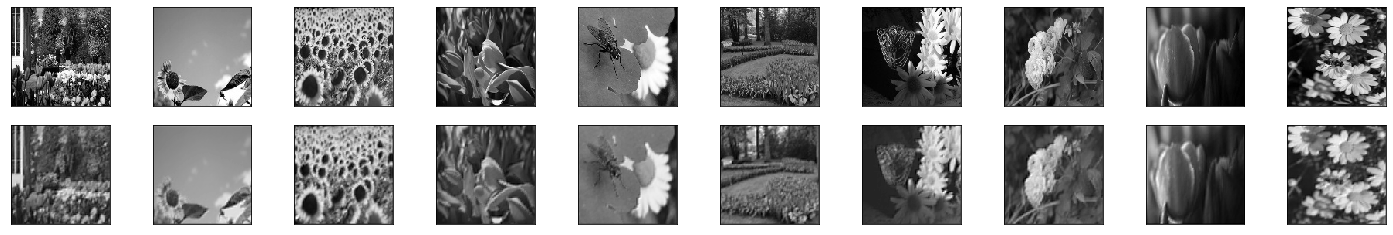

In [27]:
# obtain one batch of test images
dataiter = iter(valid_loader)
source, target = dataiter.next()

if train_on_gpu:
  source, target = source.cuda(), target.cuda()

# get sample outputs
output = model(source)
# prep images for display
source = source.cpu().detach().numpy()
target = target.cpu().detach().numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 128, 128)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([target, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [0]:
model